# Vector Autoregression (VAR) for RBA

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [78]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
auth.authenticate_user()

## Upgrade networkx
!pip install networkx --upgrade

# data processing libraries
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from scipy.optimize import least_squares
import datetime
import networkx as nx
from sklearn import preprocessing
from matplotlib import pyplot as plt

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat.python import lrange

#adhoc_import.InitializeFromSrcfs() # Plotly uses dynamic imports
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
bigquery.USE_LEGACY_SQL = False
magics.context.project = '' #list BQ project name
client = bigquery.Client(project=magics.context.project)


%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

In [ ]:
'''
Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "ts"
'''

In [ ]:
# %%bigquery ts
# SELECT *
# FROM `.RBA_demo.cleaned_data`; #update project name

In [66]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
# df = pd.read_csv(file_name)
# df.fillna(0, inplace=True)
# df.head()

#update file name and name ts

ts_raw = pd.read_csv(file_name)
ts_raw.fillna(0, inplace=True)
ts = ts_raw.drop(columns = ['Date','DIV_GMOC_SHOP_ESSl21_0p0_0d0_0']).copy()
## Drop DIV_GMOC_SHOP_ESS which has high correlation

ts.head()


,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,C_DIV_GETNOW_ESSl21_0p0_0d0_12,...,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_WYG_PPl21_0p0_0d0_12,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,729,-1.10816,0.17821,-0.77445,0.62777,-0.26476,-0.14665,-0.31105,1.42270,-0.38974,...,-0.69047,-0.39809,-0.62489,-0.18989,-1.32979,-0.26314,-0.97018,0.06041,-0.31053,0
1,936,-0.59164,-1.33958,-0.21066,-0.06009,1.58945,-0.64785,0.22599,0.82868,-0.39316,...,-0.71784,-0.34716,-0.19110,-0.42186,-0.88507,-0.36844,-0.97018,-0.08295,0.64971,0
2,787,-1.53217,-1.82612,-1.84357,-1.18277,-1.07046,-1.48568,0.97349,-1.00141,-0.48905,...,-0.77258,-0.82760,-0.32007,-1.33685,-1.40562,-1.46006,-0.97018,-0.14439,-1.10770,0
3,1030,-0.78052,-1.19679,-0.37353,0.17870,-0.68416,-0.64037,-1.52301,-0.60203,-0.72762,...,-0.71427,-0.07582,1.07937,1.42907,0.47379,0.64719,0.53969,0.02627,-1.21641,0
4,950,-0.96554,-0.98526,-0.27748,-1.16139,-0.37513,-0.90219,-1.31255,0.12343,0.58624,...,-0.28822,0.46830,0.52940,1.57136,-0.31637,0.11497,-0.78900,-0.97724,-1.21641,0


In [44]:
'''
Set the frequency of the dataset to either daily or weekly.
If the data is daily, there is a default number of lags (7)
and if the data is weekly, there is a default number of lags (4)
'''

'\nSet the frequency of the dataset to either daily or weekly.\nIf the data is daily, there is a default number of lags (7)\nand if the data is weekly, there is a default number of lags (4)\n'

In [67]:
frequency = "Daily"  #["Daily", "Weekly"]

In [68]:
ts = pd.DataFrame([pd.to_numeric(ts[c]) for c in ts.columns]).transpose()
ts = ts.reset_index(drop = True)

if frequency == 'Daily':
  maxlag = 7
elif frequency == 'Weekly':
  maxlag = 4

In [69]:
ts.head()
#ts.info()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,C_DIV_GETNOW_ESSl21_0p0_0d0_12,...,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_WYG_PPl21_0p0_0d0_12,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,729.00000,-1.10816,0.17821,-0.77445,0.62777,-0.26476,-0.14665,-0.31105,1.42270,-0.38974,...,-0.69047,-0.39809,-0.62489,-0.18989,-1.32979,-0.26314,-0.97018,0.06041,-0.31053,0.00000
1,936.00000,-0.59164,-1.33958,-0.21066,-0.06009,1.58945,-0.64785,0.22599,0.82868,-0.39316,...,-0.71784,-0.34716,-0.19110,-0.42186,-0.88507,-0.36844,-0.97018,-0.08295,0.64971,0.00000
2,787.00000,-1.53217,-1.82612,-1.84357,-1.18277,-1.07046,-1.48568,0.97349,-1.00141,-0.48905,...,-0.77258,-0.82760,-0.32007,-1.33685,-1.40562,-1.46006,-0.97018,-0.14439,-1.10770,0.00000
3,1030.00000,-0.78052,-1.19679,-0.37353,0.17870,-0.68416,-0.64037,-1.52301,-0.60203,-0.72762,...,-0.71427,-0.07582,1.07937,1.42907,0.47379,0.64719,0.53969,0.02627,-1.21641,0.00000
4,950.00000,-0.96554,-0.98526,-0.27748,-1.16139,-0.37513,-0.90219,-1.31255,0.12343,0.58624,...,-0.28822,0.46830,0.52940,1.57136,-0.31637,0.11497,-0.78900,-0.97724,-1.21641,0.00000


## 2) Helper functions

In [70]:
def get_coeff(X):
  x = 0
  for i in range(0, X.shape[0]):
    x += X[i][0][1]
  return x

In [71]:
def get_factor(Y):
  i = ts[impulse].astype(float).std()
  r  = ts[response].astype(float).std()
  fact = (get_coeff(Y)*r/i)
  return fact

In [72]:
def mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return(mape)

In [73]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

## 3) Pre-testing

### 3.1) Granger causality

In [ ]:
'''
5-10% is a good statistical significance threshold for importance assuming there
is sufficient length of data (i.e. 2 years). Otherwise, be flexible and look at 15%
but recognize that these varaibles might need further review.
'''

'\n5-10% is a good statistical significance threshold for importance assuming there \nis sufficient length of data (i.e. 2 years). Otherwise, be flexible and look at 15% \nbut recognize that these varaibles might need further review.\n'

In [74]:
def grangers_causation_matrix(data, variab, maxlag, test='ssr_chi2test', verbose=False):
  df = pd.DataFrame(np.zeros((variab.shape[0], variab.shape[0])), columns=variab, index=variab)
  for c in df.columns:
    for r in df.index:
      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      df.loc[r, c] = min_p_value
  df.columns = [var + '_cause' for var in variab]
  df.index = [var + '_effect' for var in variab]
  return df

In [75]:
grangers_causation_matrix(ts, variab = ts.columns, maxlag = maxlag)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,A_OC_GOOGLE_SHOPPING_cause,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12_cause,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12_cause,C_DIV_BUY_PREMIUMl21_0p0_0d0_12_cause,C_DIV_BUY_SSl21_0p0_0d0_06_cause,C_DIV_CONN_DATAl21_0p0_0d0_06_cause,C_DIV_CONN_REMOTEl21_0p0_0d0_12_cause,C_DIV_CONN_TRYl21_0p0_0d0_06_cause,C_DIV_GETNOW_CONNl21_0p0_0d0_06_cause,C_DIV_GETNOW_ESSl21_0p0_0d0_12_cause,...,DIV_PLANPAGE_ESSl21_0p0_0d0_0_cause,DIV_WYG_PPl21_0p0_0d0_12_cause,OC_APP_Accessl21_0p0_0d0_12_cause,OC_PAGE_PREFl21_0p0_0d0_06_cause,OC_PAGE_PREFPLl21_0p0_0d0_12_cause,OC_PAGE_PREMl21_0p0_0d0_12_cause,SC_BUYNOWl21_0p0_0d0_12_cause,SC_HOMEPAGEl21_0p0_0d0_12_cause,SC_SHOPNOWl21_0p0_0d0_06_cause,Is_Holiday_cause
A_OC_GOOGLE_SHOPPING_effect,1.00000,0.11020,0.11470,0.11680,0.22530,0.64720,0.03880,0.19160,0.08010,0.71050,...,0.00370,0.02290,0.01670,0.12680,0.02220,0.07930,0.08900,0.21940,0.04100,0.25370
C_DIV_BUY_CONNECTEDl21_0p0_0d0_12_effect,0.12780,1.00000,0.05810,0.13610,0.09050,0.32390,0.27170,0.37640,0.00010,0.11430,...,0.52050,0.00040,0.00200,0.00340,0.33470,0.03130,0.00020,0.05410,0.00450,0.36200
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12_effect,0.59810,0.14730,1.00000,0.34600,0.03860,0.01290,0.02490,0.21040,0.00000,0.43180,...,0.47980,0.00160,0.04870,0.18060,0.05310,0.09890,0.32270,0.38590,0.17220,0.37320
C_DIV_BUY_PREMIUMl21_0p0_0d0_12_effect,0.29470,0.00500,0.04070,1.00000,0.00190,0.28330,0.06560,0.56700,0.03540,0.00620,...,0.13420,0.00350,0.09860,0.02370,0.02470,0.03290,0.11190,0.06990,0.05950,0.05370
C_DIV_BUY_SSl21_0p0_0d0_06_effect,0.26930,0.05580,0.31360,0.16830,1.00000,0.16390,0.02600,0.45110,0.00000,0.54670,...,0.46110,0.00280,0.41210,0.26990,0.00940,0.06550,0.39960,0.18660,0.03210,0.84840
C_DIV_CONN_DATAl21_0p0_0d0_06_effect,0.41820,0.00090,0.09340,0.01650,0.23070,1.00000,0.27000,0.06480,0.00490,0.49640,...,0.00230,0.02910,0.00500,0.33100,0.38820,0.28610,0.00600,0.04840,0.08980,0.56120
C_DIV_CONN_REMOTEl21_0p0_0d0_12_effect,0.09190,0.28170,0.36210,0.15160,0.70490,0.22300,1.00000,0.42470,0.16660,0.74260,...,0.61260,0.05180,0.00050,0.20720,0.00910,0.00500,0.07950,0.24730,0.00730,0.16790
C_DIV_CONN_TRYl21_0p0_0d0_06_effect,0.05740,0.00530,0.06380,0.00130,0.08490,0.00000,0.30120,1.00000,0.00300,0.00600,...,0.01700,0.00890,0.04900,0.00170,0.00000,0.00770,0.29210,0.05030,0.27570,0.00010
C_DIV_GETNOW_CONNl21_0p0_0d0_06_effect,0.03010,0.00540,0.11470,0.11440,0.01410,0.12360,0.34580,0.01640,1.00000,0.26630,...,0.27340,0.01520,0.12070,0.10600,0.05450,0.18740,0.04400,0.14500,0.18050,0.48710
C_DIV_GETNOW_ESSl21_0p0_0d0_12_effect,0.12610,0.14050,0.19130,0.28560,0.43030,0.06630,0.00240,0.00210,0.09740,1.00000,...,0.05890,0.03420,0.44150,0.08890,0.68300,0.40790,0.08970,0.27410,0.41440,0.69230


In [76]:
#@title Run Granger Causality Test  {run: 'auto'}
significance_level = 0.05 #@param {type:"slider", min:0, max:0.3, step:0.001}
lag = 5        #@param {type:'integer'}

In [80]:
gc = grangers_causation_matrix(ts, ts.columns, maxlag = lag)

gc1 = gc.stack().reset_index().rename(columns = {"level_0":"effect", "level_1":"cause", 0:"causation?"})
gc1['causation?'] = gc1['causation?'].apply(lambda x: 1 if x <= significance_level else 0)
gc1 = gc1.pivot(index = 'cause', columns = 'effect', values = 'causation?')

## from_numpy_matrix is no longer working

# G = nx.from_numpy_matrix(gc1.values,
#                          parallel_edges=True,
#                          create_using=nx.DiGraph())

G = nx.DiGraph(gc1.values,
                         parallel_edges=True,
                         create_using=nx.DiGraph())



label_mapping = pd.Series(ts.columns, list(range(0, gc1.index.size))).to_dict()
G = nx.relabel_nodes(G, label_mapping)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

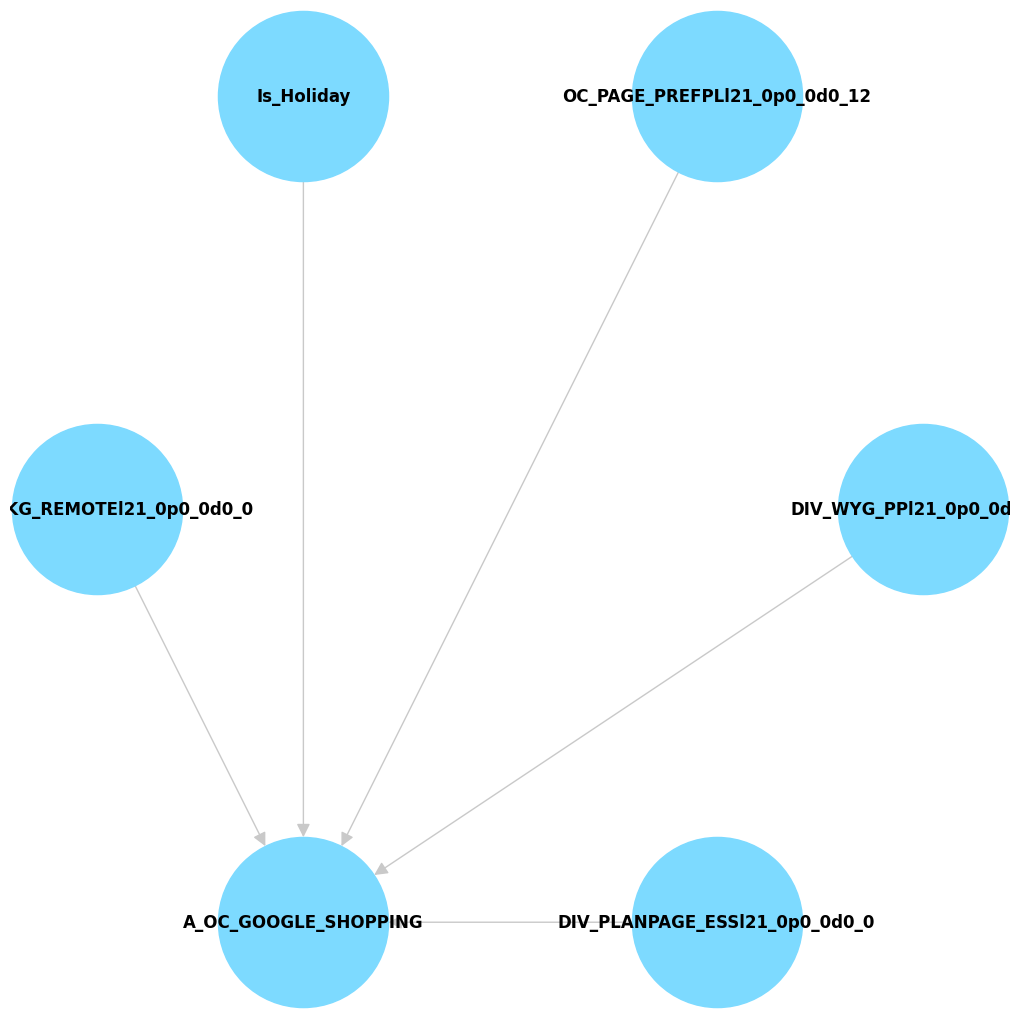

In [81]:
#@title Explore Granger Causality Graphs  {run: 'auto'}
CausalDirection = "In" #@param ["In", "Out"]
Variable ="A_OC_GOOGLE_SHOPPING"  #@param {type:"string"}

if CausalDirection == 'In':
  Graph = G.in_edges([Variable])
else:
  Graph = G.out_edges([Variable])

H = nx.from_edgelist(Graph,
                     create_using=nx.DiGraph())
plt.figure(figsize =(10, 10))

#the color & size of the cause or effect should be different than the rest
# https://stackoverflow.com/questions/27030473/how-to-set-colors-for-nodes-in-networkx
#dim other nodes
nx.draw_shell(H,
              arrows=True,
              with_labels=True,
              arrowsize=20,
              # arrowstyle='simple',
              font_color = 'black',
              font_weight = 'bold',
              node_color = '#7ddaff',
              node_size = 15000,
              width = 1,
              edge_color = '#c9c9c9')

### 3.2) Stationarity

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
#Tests for Stationarity
regressionDictionary = {
    'c'  : 'Constant',
    'ct' : 'Constant with Trend',
    'ctt': 'Constant with Linear and Quadratic Trend',
    'nc' : 'No Constant / No Trend'
    }

data = pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='c')[1], 5)   < 0.1 else 1 for c in ts.columns], columns=['c'], index=ts.columns).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='ct')[1], 5)  < 0.1 else 1 for c in ts.columns], columns=['ct'], index=ts.columns)).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='ctt')[1], 5) < 0.1 else 1 for c in ts.columns], columns=['ctt'], index=ts.columns)).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='nc')[1], 5)  < 0.1 else 1 for c in ts.columns], columns=['nc'], index=ts.columns))
dt = pd.DataFrame(data = data.sum(), columns = ['unit roots'])

roots   = dt[dt['unit roots'] == data.sum().min()]['unit roots'][0]
regress = dt[dt['unit roots'] == data.sum().min()].index[0]

In [ ]:
if (roots == 0):
  print('No Unit Roots present')
else:
  print('Unit Roots present')
  print('.......................')
  print('First-differencing the data')
  df = df.diff().dropna()
  print('.......................')
  print('Re-testing for unit roots')
  print('........................')
  data = pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='c')[1], 5)   < 0.1 else 1 for c in df.columns], columns=['c'], index=df.columns).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='ct')[1], 5)  < 0.1 else 1 for c in df.columns], columns=['ct'], index=df.columns)).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='ctt')[1], 5) < 0.1 else 1 for c in df.columns], columns=['ctt'], index=df.columns)).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='nc')[1], 5)  < 0.1 else 1 for c in df.columns], columns=['nc'], index=df.columns))
  dt = pd.DataFrame(data = data.sum(), columns = ['unit roots'])

  roots   = dt[dt['unit roots'] == data.sum().min()]['unit roots'][0]
  if (roots ==0):
    print('No Unit Roots present')
  else:
    print('Unit Roots still present')

Unit Roots present
First-differencing the data
.......................
Re-testing for unit roots
........................
No Unit Roots present


### 3.3) Cointegration

In [ ]:
'''
Cointegration test helps to establish the presence of a statistically significant
connection between two or more time series.

If no co-integration exists we can use the VAR model. If co-integration does exist,
we have to use the VECM model. You can also drop one co-integrated variable and
run the VAR model (this depends on the use case).

Another way to test for co-integration is to regress one variable on another and
check the residuals. If the residuals are stationary, the two series are co-integrated.
'''


def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(ts)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
index  ::  2726.06   > nan       =>   False
x8     ::  2472.93   > nan       =>   False
x9     ::  2255.65   > nan       =>   False
x10    ::  2056.2    > nan       =>   False
x11    ::  1872.25   > nan       =>   False
x12    ::  1700.95   > nan       =>   False
x14    ::  1547.03   > nan       =>   False
x16    ::  1399.08   > nan       =>   False
x26    ::  1255.98   > nan       =>   False
x27    ::  1120.51   > nan       =>   False
x28    ::  987.01    > nan       =>   False
x29    ::  869.54    > nan       =>   False
x30    ::  762.63    > nan       =>   False
x32    ::  660.71    > nan       =>   False
x33    ::  573.75    > nan       =>   False
x34    ::  489.28    > nan       =>   False
x35    ::  410.44    > 311.1288  =>   True
x37    ::  333.84    > 263.2603  =>   True
x38    ::  267.27    > 219.4051  =>   True
x39    ::  205.4     > 179.5199  =>   True
x40    ::  157.19    > 143.6691  =>

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:608: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  category=HypothesisTestWarning)


In [ ]:
#Test for Cointegration
coint = pd.DataFrame([[round(coint(ts[i], ts[j], trend = 'c')[1], 3) for i in ts.columns] for j in ts.columns], columns=ts.columns, index=ts.columns)
coint = pd.melt(coint, value_vars=coint.columns, value_name = 'p_value', ignore_index = False).reset_index()
cointVars = coint[(coint['p_value'] <= 0.1) & (coint['index'] != coint['variable'])]
cointVarsCount = cointVars.shape[0]

#Cointegrating Relationships
cointRelationships=select_coint_rank(endog = ts, det_order = 1, k_ar_diff = 1).rank

In [ ]:
if (cointVarsCount == 0):
  print('No Cointegration')
else:
  print('Cointegration present')

if (cointRelationships == 0):
  print('No Cointegrating relationships')
else:
  print({cointRelationships}, 'Cointegrating relationships')

Cointegration present
{28} Cointegrating relationships


## 4) Variable selection

In [ ]:
'''
Criteria for selecting variables:
- Granger causality
- Metrics do not have to be the same across tactics
'''

In [ ]:
ts.columns.tolist()

['index',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x14',
 'x16',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30',
 'x32',
 'x33',
 'x34',
 'x35',
 'x37',
 'x38',
 'x39',
 'x40',
 'x41',
 'x42',
 'x43',
 'x44',
 'x45',
 'x46',
 'y1']

In [ ]:
#@title Choose Variables For The Model (Paste)
variables = ['y1','x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x16', 'x26', 'x27', 'x28', 'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46']

#DO NOT EDIT CODE BELOW
ts = ts[variables]
ts[variables] = ts[variables].apply(pd.to_numeric, errors = 'coerce')

## 5) Run the model

In [ ]:
'''
If unit roots are not present, we can run a VAR model. Otherwise,
we have to run a VECM model.
'''


#Run Model
if (roots == 0):
  var = VAR(ts)
#  model = var.fit(maxlags=maxlag, ic='aic', trend = regress)
  model = var.fit()
else:
  vecm = VECM(endog=df, k_ar_diff=1, coint_rank=cointRelationships)
  model = vecm.fit()

## 6) Results

### 6.1) Visualize forecast

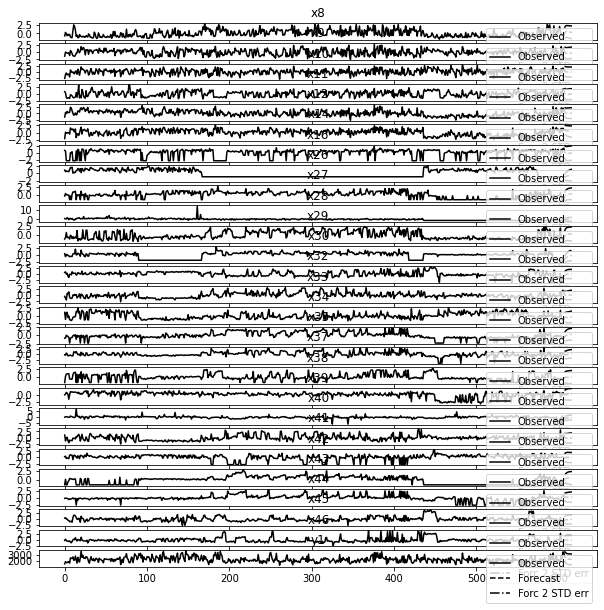

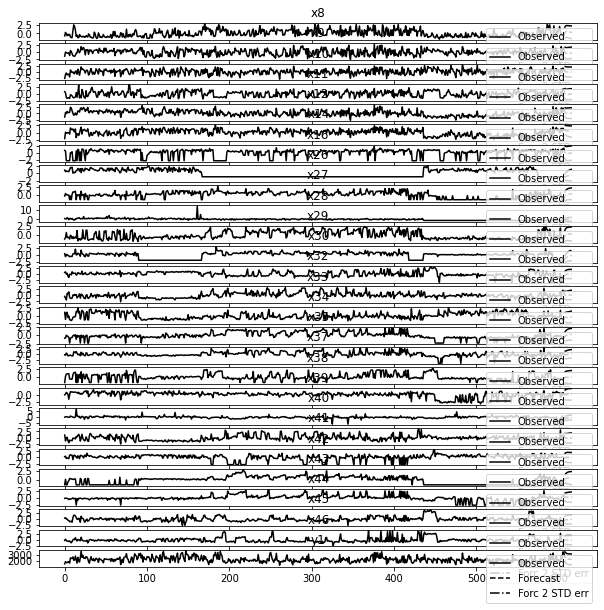

In [ ]:
model.plot_forecast(10)

### 6.2) Model output summary

In [ ]:
'''
The model summary outputs all coefficients and other summary statistics for each
equation of the VAR model.
'''

model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jan, 2022
Time:                     19:11:43
--------------------------------------------------------------------
No. of Equations:         27.0000    BIC:                   -10.7325
Nobs:                     606.000    HQIC:                  -14.0910
Log likelihood:          -17542.9    FPE:                8.95548e-08
AIC:                     -16.2302    Det(Omega_mle):     2.64509e-08
--------------------------------------------------------------------
Results for equation x8
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.716335         0.393073            1.822           0.068
L1.x8          0.090099         0.061438            1.467           0.143
L1.x9         -0.055228         0.080898           -0.683           0.495
L1.x10        -0.

### 6.3) IRFs

In [ ]:
#@title Summarize Results {run: 'auto'}
response_period = 7       #@param {type:'integer'}

periods = response_period
model = model
orth = True
svar = False

#IRF object
irf = model.irf(periods)
neqs = model.neqs
rng = lrange(neqs)

#non cumulative IRF
irfs = irf.orth_irfs
stderr = np.array(irf.errband_mc(orth=orth, svar=svar, repl=1000, signif=0.05, seed=None, burn = 100))

#cumulative IRF
irfs_cum = irf.orth_cum_effects
stderr_cum = np.array(irf.cum_errband_mc(orth=orth, repl=1000, signif=0.05, seed=None, burn = 100))

#fevd (for VAR only)
irfs2 = (irfs[:periods] ** 2).cumsum(axis=0)
mse = model.mse(periods)[:, rng, rng]
fevd = np.empty_like(irfs)
for i in range(periods):
  fevd[i] = (irfs2[i].T / mse[i]).T

decomp = fevd.swapaxes(0, 1)

#Summarize results into dataframe
df = pd.DataFrame()
for i in range(0, irfs.shape[1]):
  for r in range(0, irfs.shape[2]):
    len = irfs.shape[0]
    tab = pd.DataFrame([irfs[n][r][i] for n in range(0, irfs.shape[0])], columns=['irf'])
    tab2= pd.DataFrame([stderr[0][n][r][i] for n in range(0, stderr.shape[1])], columns=['irf stderr lower bound'])
    tab3= pd.DataFrame([stderr[1][n][r][i] for n in range(0, stderr.shape[1])], columns=['irf stderr upper bound'])
    tab4= pd.DataFrame([irfs_cum[n][r][i] for n in range(0, irfs_cum.shape[0])], columns=['cumulative irf'])
    tab5= pd.DataFrame([stderr_cum[0][n][r][i] for n in range(0, stderr_cum.shape[1])], columns=['cumulative irf stderr lower bound'])
    tab6= pd.DataFrame([stderr_cum[1][n][r][i] for n in range(0, stderr_cum.shape[1])], columns=['cumulative irf stderr upper bound'])
    tab7= pd.DataFrame([fevd[n][r][i] for n in range(0, fevd.shape[0])], columns=['fevd'])
    imp = pd.DataFrame(np.tile(model.names[r],(tab.shape[0],1)), columns=['response'])
    res = pd.DataFrame(np.tile(model.names[i],(tab.shape[0],1)), columns=['impulse'])
    num = pd.DataFrame(np.arange(1, tab.shape[0]+1), columns=['n'])
    df  = df.append(tab.join(tab2).join(tab3).join(tab4).join(tab5).join(tab6).join(tab7).join(imp).join(res).join(num))


In [ ]:
'''
IRFs are interpreted as a 1 sd increase impact on another variable's response

Top-left fig:
- A one standard deviation change in brand search clicks (i.e. 3000 incremental clicks)
at time t will show how brand search clicks will respond in the follow periods

Right-hand side figures show the cumulative effect of the impulse respond.
An additional 3K incremental clicks today resultsi n over 6K clicks 14 periods out
'''

#Explore Dynamic Incrementality {run: 'auto'}
impulse="x8"  #@param {type:"string"}
response="y1" #@param {type:"string"}
impulse_name="Clicks"  #@param {type:"string"}
response_name = "Conversions" #@param {type:"string"}


sub = df[((df['response']==response)) & (df['impulse']==impulse)][['n', 'irf', 'irf stderr lower bound', 'irf stderr upper bound', 'cumulative irf', 'cumulative irf stderr lower bound', 'cumulative irf stderr upper bound']]
sub2= df[((df['response']==impulse)) & (df['impulse']==impulse)][['n', 'irf', 'irf stderr lower bound', 'irf stderr upper bound', 'cumulative irf', 'cumulative irf stderr lower bound', 'cumulative irf stderr upper bound']]

title1 = "One Time Effects: {} -> {}".format(impulse_name, impulse_name)
title2 = "Cumulative Effects: {} -> {}".format(impulse_name, impulse_name)
title3 = "One Time Effects: {} -> {}".format(impulse_name, response_name)
title4 = "Cumulative Effects: {} -> {}".format(impulse_name, response_name)

fig = make_subplots(rows=2, cols=2, subplot_titles=(title1, title2, title3, title4))
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf'], name = 'Impulse Response Function', line = dict(color='royalblue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf stderr lower bound'], name = 'Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf stderr upper bound'], name = 'Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf'], name = 'Cumulative Impulse Response Function', line = dict(color='royalblue', width=4)), row=1, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf stderr lower bound'], name = 'Cumulative Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf stderr upper bound'], name = 'Cumulative Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=2)

fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf'], name = 'Impulse Response Function', line = dict(color='royalblue', width=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf stderr lower bound'], name = 'Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf stderr upper bound'], name = 'Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=1)

fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf'], name = 'Cumulative Impulse Response Function', line = dict(color='royalblue', width=4)), row=2, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf stderr lower bound'], name = 'Cumulative Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf stderr upper bound'], name = 'Cumulative Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=2)
fig.update_layout(title='Impulse Response Analysis', height=800, width=1800, showlegend=False)

fig.show()

### 6.4) Forecast decomposition

In [ ]:
'''
The forecast error variance decomposition partitions the total conversions by
dynamic attribution of digital media tactics.

You can visualize how the contribution of a given tactic drives conversion over
multiple periods, vs. a static view.
'''

In [ ]:
model.resid.columns

Index(['x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x16', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'y1'],
      dtype='object')

In [ ]:
# Explore Dynamic Attribution/Contribution Analysis {run: 'auto'}
variables = "y1" #@param {type: "string"}
variable_name = "Total Conversions" #@param {type:"string"}
title5 = "Dynamic Contribution to {} Analysis".format(variable_name)

fvd = df[(df['response']==variables) & (df['n']<response_period)][['n', 'impulse', 'fevd']]

fig = px.area(fvd, x='n', y='fevd', color='impulse',
              labels = {
                  "n":"Forecast Period",
                  "impulse": "Contributor",
                  "fevd": "Contribution"
              })
fig.update_layout(title=title5, height=600, width=1200)
fig.show()

## 7) Validate model assumptions

### 7.1) Whiteness of residuals - absence of significant residual autocorrelation

In [ ]:
model.test_whiteness().summary()

Test statistic,Critical value,p-value,df
7455.,6751.,0.000,6561


### 7.2) Normality of residuals - null hypothesis that the data is normally distributed

In [ ]:
'''
Normality of residuals can be visualized or tested with the normality() test
'''

In [ ]:
model.resid.columns

Index(['x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x16', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'y1'],
      dtype='object')

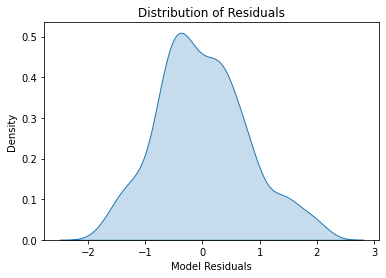

In [ ]:
sns.kdeplot(model.resid.x8, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

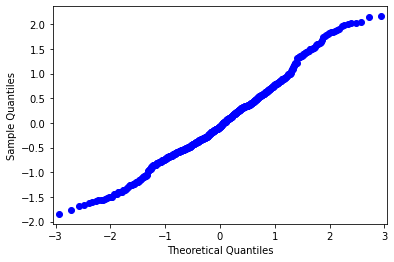

In [ ]:
fig = sm.qqplot(model.resid.x8)

In [ ]:
model.test_normality().summary()

Test statistic,Critical value,p-value,df
4.738e+05,72.15,0.000,54
